In [23]:
from dateutil.relativedelta import relativedelta
from numbers import Number
import pandas as pd

import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs

# Editing report

In [24]:
editing_metrics = pd.read_csv(
    "metrics/editing_metrics.tsv",
    sep="\t",
    parse_dates=["month"]
).set_index("month")

editing_diversity_metrics = pd.read_csv(
    "metrics/editing_diversity_metrics.tsv",
    sep="\t",
    parse_dates=["month"]
).set_index("month")

graph_end = editing_metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)
prior_month = graph_end - relativedelta(months = 1)

In [25]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = editing_metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([editing_metrics, stock_metrics], axis=1)

In [26]:
metrics_all = pd.concat([metrics, editing_diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]

In [27]:
report_order = [
     #Editors
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
        'anonymous_edits',
        'non_anonymous_edits',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'global_north_edits',
    'global_south_edits',
    #Diversity Editors
    'global_north_active_editors',
    'global_south_active_editors',
]

In [30]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_value = yr_prev 
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        yoyoyoy_value = ser[-37]
        cagr_change = (cur  / yoyoyoy_value)**(1/4) - 1
        yoyoyoy = (cur / yoyoyoy_value) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur, yoy_change, yoyoyoy, cagr_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=[
            "value",
            "change_from_year_ago",
            "change_from_3_years_ago",
            "3_yr_cagr"
        ]
    )

def add_month_header(df, metrics_type):
    month = graph_end.strftime("%Y-%m")
    header = month + " " + metrics_type + " metrics"
    new_index = pd.MultiIndex.from_product([[header], df.columns])
    
    df.columns = new_index
    
    return df

In [37]:
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    .pipe(add_month_header, "editing and content")
    .style
    .set_table_styles([{
        'selector': 'th.col_heading.level0',
        'props': 'font-size: 1.5em; text-align: center; font-weight: bold;'
    }])
)

Changing directory to:/srv/home/nshahquinn-wmf/movement-metrics/wikicharts
Generating Active Editors chart...


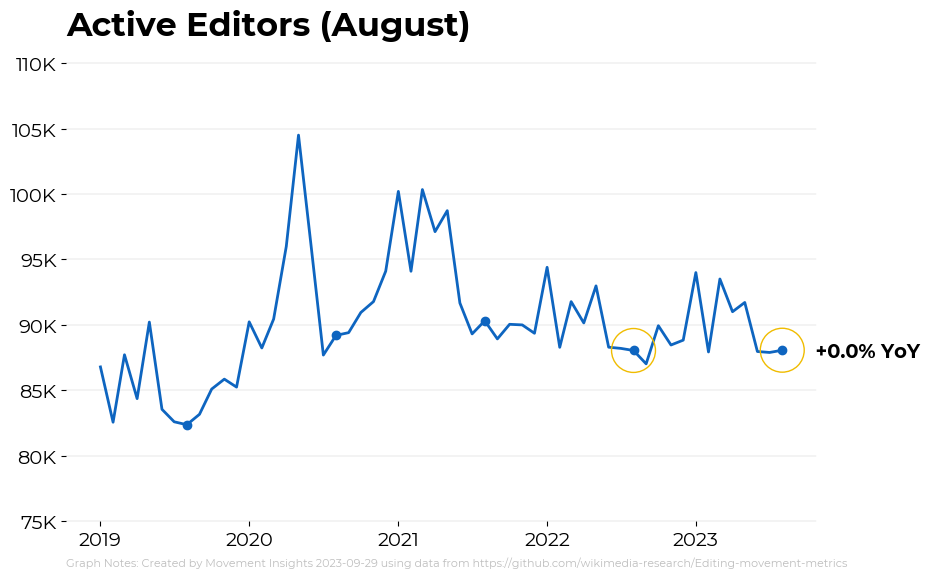

Generating New Returning chart...


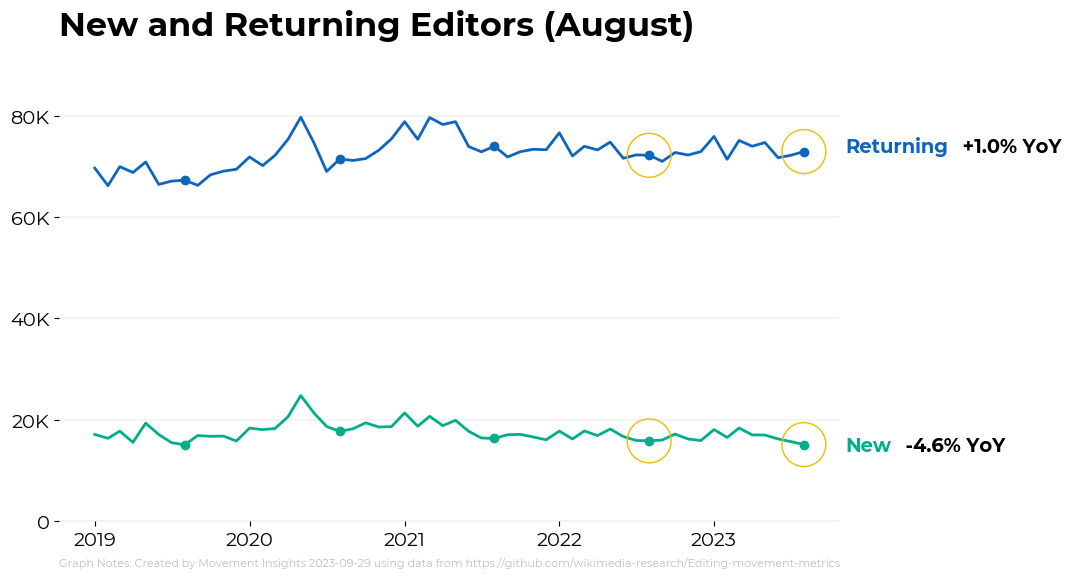

Generating Net New Content chart...


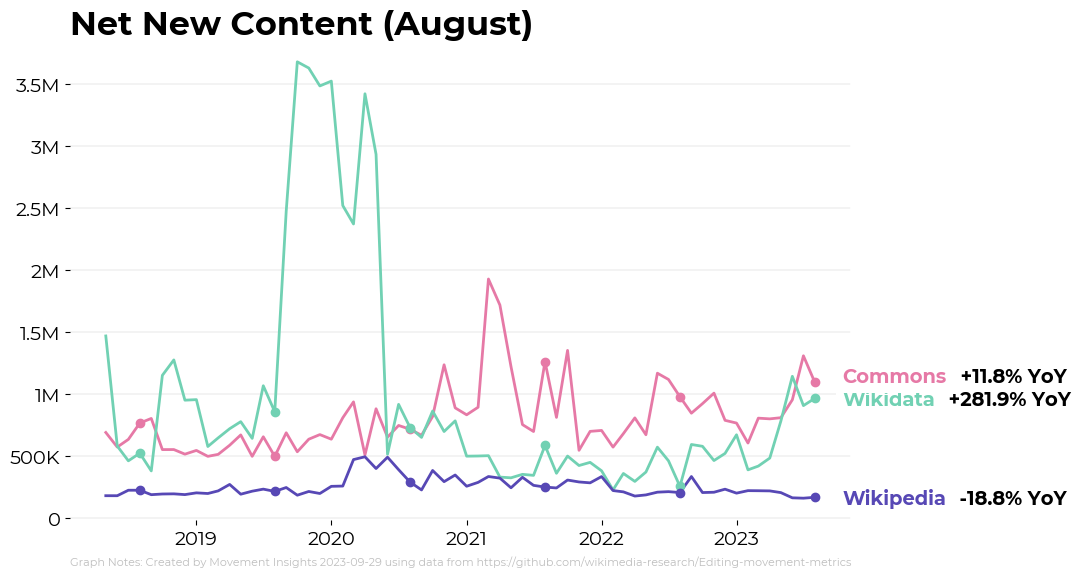

Resetting directory to:/srv/home/nshahquinn-wmf/movement-metrics/wikicharts


In [32]:
%run 'wikicharts/EDITOR_METRICS.ipynb'

# Readers report

In [33]:
readers_metrics = pd.read_csv(
    "metrics/readers_metrics.tsv",
    sep="\t",
    parse_dates=["month"]
).set_index("month")

readers_diversity_metrics = pd.read_csv(
    "metrics/readers_diversity_metrics.tsv",
    sep="\t",
    parse_dates=["month"]
).set_index("month")

In [34]:
readers_metrics_all = pd.concat([readers_metrics, readers_diversity_metrics], axis=1)
readers_metrics_all = readers_metrics_all.loc[:,~readers_metrics_all.columns.duplicated()]

In [35]:
readers_report_order = [
    'interactions', 
        'total_pageview',
        'automated_pageviews',
        'desktop', 
        'mobileweb',
        'previews_seen',
    'unique_devices',
    # Diversity
    'gn_interactions',
    'gs_interactions'
]

In [38]:
(
    readers_metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(readers_report_order)
    .fillna("—")
    .pipe(add_month_header, "readers")
    .style
    .set_table_styles([{
        'selector': 'th.col_heading.level0',
        'props': 'font-size: 1.5em; text-align: center; font-weight: bold;'
    }])
)

Changing directory to:/srv/home/nshahquinn-wmf/movement-metrics/wikicharts
Generating Content Interactions chart...


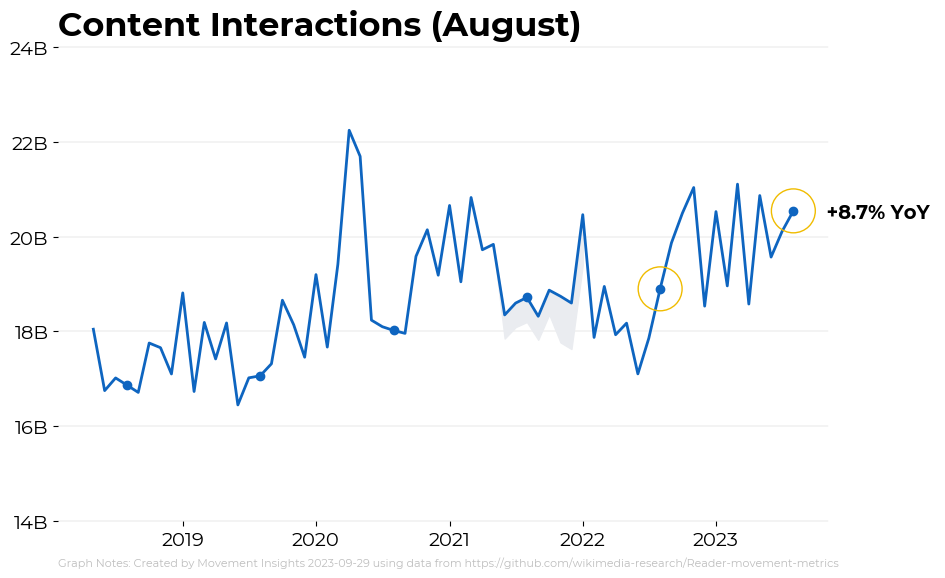

Generating Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


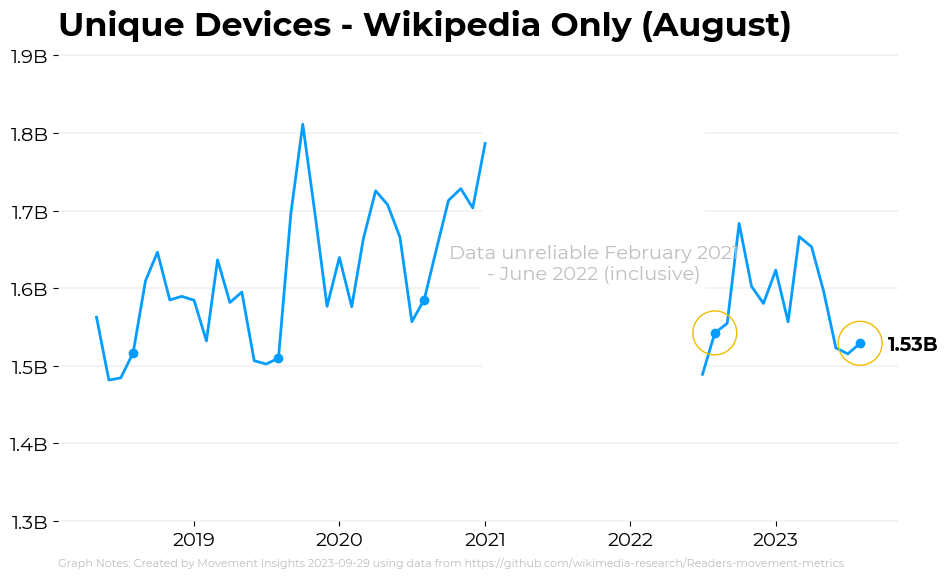

Generating Regional Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


In [ ]:
%run 'wikicharts/READER_METRICS.ipynb'